In [1]:
#Author:    Rui Ding
#Created:   04.14.2020

In [38]:
#Import packages
from sympy import *
import pandas as pd
import numpy as np
from scipy.stats import norm,mstats,spearmanr
from scipy import optimize
from scipy.optimize import Bounds
from collections import defaultdict 
from itertools import permutations
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [39]:
#Load preprocesses data and list of names
Data = np.load('DJ_data.npy')

In [40]:
l = pd.read_table('Dow Jones 30.txt',header=None)
list_stocks=l.values.reshape(1,-1)[0]
names = list(list_stocks[:-1])

In [41]:
#Identify tech and finance sectors
tech = ['CSCO','IBM','INTC','MSFT','AAPL','BA']
finance = ['AXP','GS','JPM','V']
tech_idx = [names.index(a) for a in tech]
finance_idx = [names.index(a) for a in finance]

## Defining Various Copula Structures

### Frank-Archimedean Copula Density Calculation

In [42]:
def FAP(n):
    x = symbols('x')
    if n==1:
        y = 1/x
    else:
        x,z = FAP(n-1)
        y = z+diff(z,x)*(x-1)
    return x,y

In [43]:
def function_FAP(n):
    x,y = FAP(n)
    f = lambdify(x,y, 'numpy')
    return f

In [44]:
def frank_copula_density(u,theta):
    K = len(u)
    A = 1.0/(np.exp(-theta)-1)**(K-1)
    for i in range(K):
        A*=(np.exp(-theta*u[i])-1)
    A+=1
    P = function_FAP(K)
    c = (-theta)**(K-1)*np.exp(-theta*np.sum(u))*P(A)/(np.exp(-theta)-1)**(K-1)
    return c

### Gumbel Copula Density Calculation

In [46]:
def GAP(n,theta):
    x = symbols('x')
    if n==1:
        y = x**(1.0/theta - 1)
    else:
        x,z = GAP(n-1,theta)
        y = x**(1.0/theta - 1)*z-theta*diff(z,x)
    return x,y

In [47]:
def function_GAP(n,theta):
    x,y = GAP(n,theta)
    f = lambdify(x,y, 'numpy')
    return f

In [48]:
def gumbel_copula_density(u,theta):
    K = len(u)
    A = np.sum((-np.log(u))**theta)

    P = function_GAP(K,theta)
    c = P(A)*np.exp(-A**(1.0/theta))
    for i in range(K):
        c*=(-np.log(u[i]))**(theta-1) / u[i]
    return c

### Clayton Copula Density Calculation

In [50]:
def clayton_copula_density(u,theta):
    K = len(u)
    c = (np.sum(np.array(u)**(-theta))+1-K)**(-1.0/theta-K)
    for i in range(K):
        c *= (u[i])**(-theta-1) * (1+theta*i)
    return c

### Uniform Correlation Gaussian Copula Density Calculation

In [52]:
def gaussian_copula_density(u,rho):
    K = len(u)
    sig = np.ones((K,K))*rho
    for i in range(K):
        sig[i][i] = 1
    sig_inv = np.linalg.inv(sig)
    I = np.eye(K)
    v = np.array([[norm.ppf(u_i) for u_i in u]])
    a = np.dot(np.dot(v,sig_inv-I),v.T)
    c = np.exp(-0.5*a)/np.sqrt(np.linalg.det(sig))
    return c[0][0]

### Copula Density Ratio Calculation and Likelihood Evaluation

In [54]:
def copula_ratio(u,p,copula = 'Gaussian'):
    if copula=="Gaussian":
        r_c = gaussian_copula_density(u,p)/gaussian_copula_density(u[1:],p)
    elif copula=="Frank-Archimedean":
        r_c = frank_copula_density(u,p)/frank_copula_density(u[1:],p)
    elif copula == "Gumbel-Archimedean":
        r_c = gumbel_copula_density(u,p)/gumbel_copula_density(u[1:],p)
    elif copula == "Clayton-Archimedean":
        r_c = clayton_copula_density(u,p)/clayton_copula_density(u[1:],p)
    else:
        r_c = 1
    return r_c
def llh_local(p,F,u,c_type):
    #Log-likelihood summed over the dataset for a single local copula group
    M,N = F.shape
    l=0
    for m in range(M):
        r_c = copula_ratio(F[m,u],p,copula=c_type)
        l+=np.log(r_c)
    return l
def likelihood(P,F,f,G,c_type):
    #Full log-likelihood by summing local log-likelihoods and the marginal densities
        M,N = F.shape
        l=0
        for i in range(N):
            l+=np.sum(np.log(f[:,i]))
        for i in range(len(G)):
            u = G[i]
            if len(u)>1:
                l+=llh_local(P[i],F,u,c_type)
            else:
                pass
        return l

## Copula Bayesian Network Class

#### Directed Network Graph Using Networkx

In [55]:
class CBN:  
    def __init__(self, N, G, param_c=0.5, param_f = [1.06,-0.2], c_type = 'Gaussian'):
        self.N = N
        self.construct_directed_graph(G)
        self.num_copula = len(G)
        self.local_copula = c_type
        self.p_0 = param_c
        self.param_c = np.ones(len(G))*param_c
        self.h_const = param_f[0]
        self.h_power = param_f[1]
    def construct_directed_graph(self,G):
        #Construct DiGraph from given dependency list
        self.G = G
        self.K = len(G)
        g = nx.DiGraph() 
        g.add_nodes_from(list(range(self.N)))
        for l in G:
            child = l[0]
            for i in range(1,len(l)):
                parent = l[i]
                g.add_edge(parent,child)
        self.graph = g
    def update_G(self):
        #Update list G and reset parameters based on updated graph
        self.G = graph_to_list(self.graph)
        self.K = len(self.G)
        self.param_c = np.ones(self.K)*self.p_0
    def update_graph(self):
        #Update graph based on changed dependency list G
        self.K = len(self.G)
        self.param_c = np.ones(self.K)*self.p_0
        g = nx.DiGraph() 
        g.add_nodes_from(list(range(self.N)))
        for l in self.G:
            child = l[0]
            for i in range(1,len(l)):
                parent = l[i]
                g.add_edge(parent,child)
        self.graph = g
    def check_acyclic(self):
        flag = nx.is_directed_acyclic_graph(self.graph)
        return flag
    def draw_network(self,names=None):
        if names==None:
            nx.draw(self.graph,with_labels=True)
        else:
            keys = sorted(self.graph.nodes)
            mapping = {}
            for i in range(len(keys)):
                mapping[keys[i]] = names[i]

            H = nx.relabel_nodes(self.graph, mapping)
            nx.draw(H,with_labels=True)
        plt.draw()
        plt.show()
    def marginal_density_estimate(self,D):
        M = len(D)
        N = len(D[0])
        self.N = N
        F = np.zeros((M,N))
        f = np.zeros((M,N))
        for i in range(N):
            x = D[:,i]
            #Winsorized cdf estimate truncation threshold
            delta = 1.0/(4*M**0.25*np.sqrt(np.log(M)*np.pi))
            x_ = mstats.winsorize(x, limits=[delta, delta]).data
            s = np.std(x)
            #Kernel pdf estimate bandwidth
            h = self.h_const*s*M**(self.h_power)
            for j in range(M):
                F[j,i] = np.sum(1.0*(x<=x_[j]))/(M+1)
                f[j,i] = (1.0/(M*h))*np.sum(np.exp(-0.5*(x-D[j,i])**2)/h**2)/np.sqrt(2*np.pi)
        self.D = D
        self.F = F
        self.f = f
        self.M = M
        return F,f 
    def mle(self):
        p_0 = self.p_0
        neg_llh_local = lambda x,F,u,c: -llh_local(x,F,u,c)
        if self.local_copula=='Frank-Archimedean':
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([0.01],[np.inf]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
        elif self.local_copula=='Gumbel-Archimedean':
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([1.0],[np.inf]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
        elif self.local_copula=='Clayton-Archimedean':
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([0.01],[np.inf]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
        else:
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([0.01],[0.99]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
        #Update likelihood and BIC score for current network and optimal parameters
        self.likelihood = likelihood(self.param_c,self.F,self.f,self.G,self.local_copula)
        self.BIC = -2*self.likelihood+np.log(self.N)*self.K
        return self.param_c, self.likelihood, self.BIC
    

#### Helper Functions

In [56]:
def scoring(cbn):
    opt_p,l,s = cbn.mle()
    return -s
def graph_to_list(g):
    d = {}
    for e in list(g.edges):
        if e[1] not in d.keys():
            d[e[1]] = [e[0]]
        else:
            d[e[1]].append(e[0])
    G = []
    for key in d.keys():
        l = d[key]
        full = [key]+list(l)
        G.append(full)
    return G

In [57]:
def HCS(D,N,p_0,copula,cur = []):
    #Hill climbing search
    E = list(permutations(range(N), r=2))
    cbn = CBN(N,cur,param_c = p_0, c_type = copula)
    F,f = cbn.marginal_density_estimate(D)
    g_old = cbn.graph
    g_opt = g_old
    score_old = scoring(cbn)
    score_opt = score_old
    start = True
    if not nx.is_directed_acyclic_graph(g_old):
        print('Input graph is cyclic.')
        return g_old,cur
    while score_opt>score_old or start:
        start=False
        score_old = score_opt
        g_old = g_opt
        for e in E:
            A = []
            if e in g_old.edges:
                A = ['revert','delete']
            elif e[::-1] in g_old.edges:
                pass
            else:
                A = ['add']
            for a in A:
                g = g_old.copy()
                if a=='delete':
                    g.remove_edge(e[0],e[1])
                elif a=='revert':
                    g.remove_edge(e[0],e[1])
                    g.add_edge(e[1],e[0])
                else:
                    g.add_edge(e[0],e[1])
                cbn.graph = g
                cbn.update_G()
                if cbn.check_acyclic():
                    score = scoring(cbn)
                    if score>score_opt:
                        g_opt = g
                        score_opt = score
                    else:
                        pass
                else:
                    continue
    cbn.graph = g_opt
    cbn.update_G()
    opt_p,l,s = cbn.mle()
    print('Optimal likelihood: '+str(l))
    print('Optimal BIC: '+str(s))
    return cbn 

In [58]:
def SPS(D,N,p_0,copula,nbhd = 2, cur = []):
    #Spearman's rho proxy search
    cbn = CBN(N,cur,param_c = p_0, c_type = copula)
    F,f = cbn.marginal_density_estimate(D)
    S_R = spearmanr(F,axis=0)[0]
    E = []
    for i in range(N):
        r = S_R[i]
        top = r.argsort()[-nbhd-1:][::-1]
        for j in range(nbhd):
            E.append((i,top[j+1]))
            E.append((top[j+1],i))
    E = set(E)
    print(E)
    g_old = cbn.graph
    g_opt = g_old
    score_old = scoring(cbn)
    score_opt = score_old
    start = True
    if not nx.is_directed_acyclic_graph(g_old):
        print('Input graph is cyclic.')
        return g_old,cur
    while score_opt>score_old or start:
        start=False
        score_old = score_opt
        g_old = g_opt
        for e in E:
            A = []
            if e in g_old.edges:
                A = ['revert','delete']
            elif e[::-1] in g_old.edges:
                pass
            else:
                A = ['add']
            for a in A:
                g = g_old.copy()
                if a=='delete':
                    g.remove_edge(e[0],e[1])
                elif a=='revert':
                    g.remove_edge(e[0],e[1])
                    g.add_edge(e[1],e[0])
                else:
                    g.add_edge(e[0],e[1])
                cbn.graph = g
                cbn.update_G()
                if cbn.check_acyclic():
                    score = scoring(cbn)
                    if score>score_opt:
                        g_opt = g
                        score_opt = score
                    else:
                        pass
                else:
                    continue
    cbn.graph = g_opt
    cbn.update_G()
    opt_p,l,s = cbn.mle()
    print('Optimal likelihood: '+str(l))
    print('Optimal BIC: '+str(s))
    return cbn 

## Tests

### Comparing Copula Assumptions

In [59]:
#Data input
N = 4
M = 250
D = Data[-M:,:N]
label = names[:N]
copula = 'Clayton-Archimedean'
p_0 = 1.0

Clayton

In [62]:
cbn_cl=SPS(D,N,p_0,copula,nbhd=2,cur = [])

{(0, 1), (3, 2), (1, 3), (3, 0), (3, 1), (2, 0), (2, 3), (1, 0), (0, 2), (0, 3)}
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -71.27166180895914
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -34.103812847352984
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.56481838359474
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.22637205948396
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.56481838359474
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -37.474697731085925
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -71.27166180898915
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.56481838359474
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.42359540846688
            Iterations: 4
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -71.27166180898915
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -37.474697731085925
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.42359540846688
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -71.27166180895914
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -37.474697731085925
            Iterations: 3
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.42359540846688
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -71.27166180898915
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimal likelihood: 13036.483553034079
Optimal BIC: -26068.808222984797


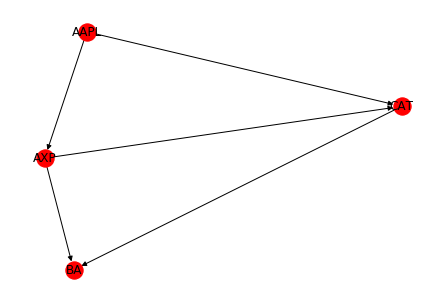

In [91]:
#optimal structure
nx.drawing.layout.spectral_layout(cbn_cl.graph)
cbn_cl.draw_network(names=label)

In [79]:
np.save('clayton_graph.npy',cbn_cl.G)
np.save('clayton_params.npy',cbn_cl.param_c)

Gaussian

In [64]:
copula = 'Gaussian'
p_0 = 0.5
cbn_g=SPS(D,N,p_0,copula,nbhd=2,cur = [])

{(0, 1), (3, 2), (1, 3), (3, 0), (3, 1), (2, 0), (2, 3), (1, 0), (0, 2), (0, 3)}
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.33966096654375
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -26.421489308490198
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.05985668414051
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -62.71602514549956
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.33966096654375
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -24.583532553077944
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.05985668414051
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.33966096654375
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -83.01917082251877
            Iterations: 7
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -83.01917082251877
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -31.78810990619571
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.33966096654375
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.05985668414051
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -26.421489308490198
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.33966096654375
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -62.71602514549956
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -31.78810990619571
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.68120795971437
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -62.71602514549956
            Iterations: 7
            Function evaluat

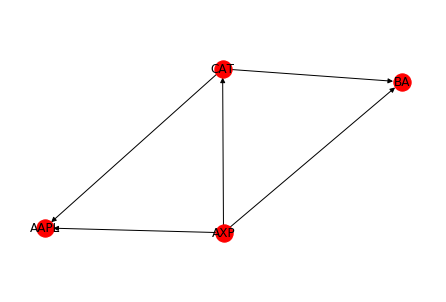

In [97]:
nx.drawing.layout.spectral_layout(cbn_g.graph)
cbn_g.draw_network(names=label)

In [81]:
np.save('gaussian_graph.npy',cbn_g.G)
np.save('gaussian_params.npy',cbn_g.param_c)

Gumbel

In [77]:
copula = 'Gumbel-Archimedean'
p_0 = 2.0
cbn_gu=SPS(D,N,p_0,copula,nbhd=2,cur = [])

{(0, 1), (3, 2), (1, 3), (3, 0), (3, 1), (2, 0), (2, 3), (1, 0), (0, 2), (0, 3)}
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -69.72474903729581
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -30.012784530182078
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -60.52805861902361
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -62.81404460426075
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -30.012784530177818
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -62.81404460426075
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -69.72474903729581
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -25.16383575202262
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -62.81404460426075
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -62.81404460420691
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -30.012784530182078
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.99536831668621
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -30.012784530182078
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -69.72474903729581
            Iterations: 5
            Function evalu

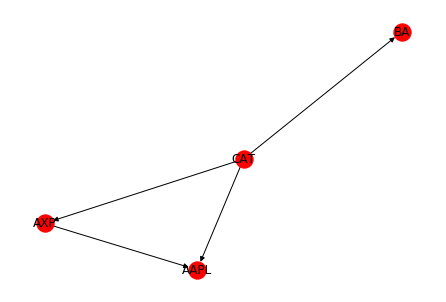

In [100]:
nx.drawing.layout.spectral_layout(cbn_gu.graph)
cbn_gu.draw_network(names=label)

In [82]:
np.save('gumbel_graph.npy',cbn_gu.G)
np.save('gumbel_params.npy',cbn_gu.param_c)

Frank

In [84]:
copula = 'Frank-Archimedean'
p_0 = 1.0
cbn_fr=SPS(D,N,p_0,copula,nbhd=2,cur = [])

{(0, 1), (3, 2), (1, 3), (3, 0), (3, 1), (2, 0), (2, 3), (1, 0), (0, 2), (0, 3)}
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.262342726427526
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -25.743156799648485
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -53.51073119584997
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -58.05399155189511
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current functi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.262342727872365
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -74.68773443326586
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.262342727872365
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -50.89561370743585
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.262342727872365
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.262342727872365
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -53.51073119584997
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -25.743156799648485
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -69.4329027501126
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.262342727872365
            Iterations: 5
            Function evalu

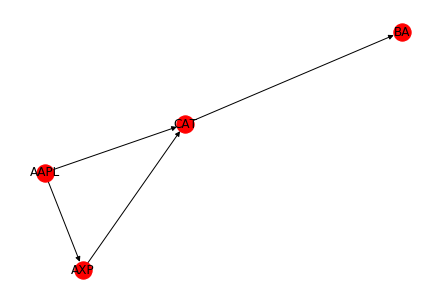

In [107]:
nx.drawing.layout.spectral_layout(cbn_fr.graph)
cbn_fr.draw_network(names=label)

In [86]:
np.save('frank_graph.npy',cbn_fr.G)
np.save('frank_params.npy',cbn_fr.param_c)

#### Sampling from Gaussian CBN

In [64]:
#Reload learned CBN 
G = list(np.load('gaussian_graph.npy',allow_pickle=True))
params = np.load('gaussian_params.npy')
#Select a local copula group, sample from the child and the first parent
local = 0
pair = G[local]
param = params[local]
X1 =np.random.normal(0,1,M)
X2 = param*X1+np.sqrt(1-param**2)*np.random.normal(0,1,M)
X = np.array([[np.quantile(D[:,pair[0]],norm.cdf(X1[i])),np.quantile(D[:,pair[1]],norm.cdf(X2[i]))] for i in range(M)])

Text(0.5, 1.0, 'Real Returns')

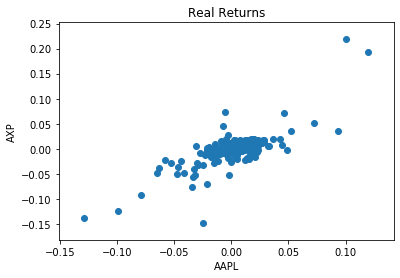

In [65]:
plt.scatter(D[:,pair[0]],D[:,pair[1]])
plt.xlabel(label[pair[0]])
plt.ylabel(label[pair[1]])
plt.title('Real Returns')

Text(0.5, 1.0, 'CBN Sampled Returns')

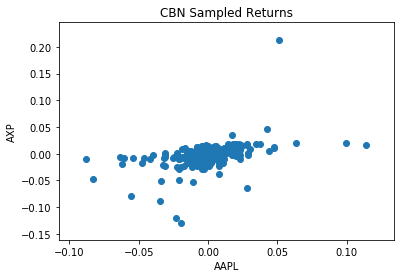

In [66]:
plt.scatter(X[:,0],X[:,1])
plt.xlabel(label[pair[0]])
plt.ylabel(label[pair[1]])
plt.title('CBN Sampled Returns')

Text(0.5, 1.0, 'Real Returns')

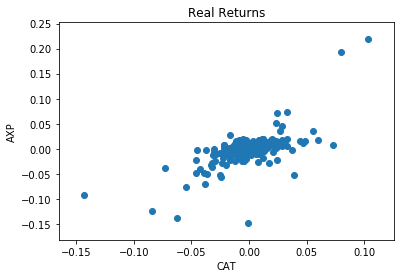

In [71]:
#Another pair
local = 1
pair = G[local]
param = params[local]
X1 =np.random.normal(0,1,M)
X2 = param*X1+np.sqrt(1-param**2)*np.random.normal(0,1,M)
X = np.array([[np.quantile(D[:,pair[0]],norm.cdf(X1[i])),np.quantile(D[:,pair[1]],norm.cdf(X2[i]))] for i in range(M)])
plt.scatter(D[:,pair[0]],D[:,pair[1]])
plt.xlabel(label[pair[0]])
plt.ylabel(label[pair[1]])
plt.title('Real Returns')

Text(0.5, 1.0, 'CBN Sampled Returns')

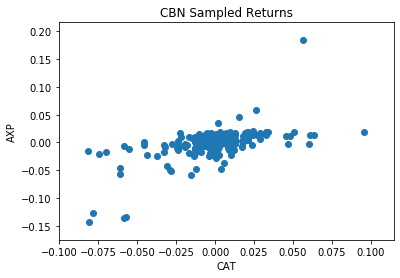

In [72]:
plt.scatter(X[:,0],X[:,1])
plt.xlabel(label[pair[0]])
plt.ylabel(label[pair[1]])
plt.title('CBN Sampled Returns')

### Performing Tech&Finance Sector Network Search Based on Spearman's Rho Proxy

In [32]:
L = tech_idx+finance_idx
N = len(L)
M = 250
D = Data[-M:,L]
label = np.array(names)[L]

In [33]:
copula = 'Clayton-Archimedean'
p_0 = 1.0

In [34]:
cbn_prox = SPS(D,N,p_0,copula,nbhd=1,cur = [])

{(0, 1), (6, 7), (7, 6), (9, 3), (5, 7), (3, 9), (7, 5), (8, 7), (0, 4), (4, 2), (1, 0), (7, 8), (2, 4), (4, 0)}
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169385
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.5294482808309
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mo

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -165.4134240559162
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -111.08344706902179
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function ev

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -165.4134240559162
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264727732
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eva

            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eva

            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -39.60912721236247
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Itera

            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -39.60912721236247
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
          

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eval

            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -39.60912721236247
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Itera

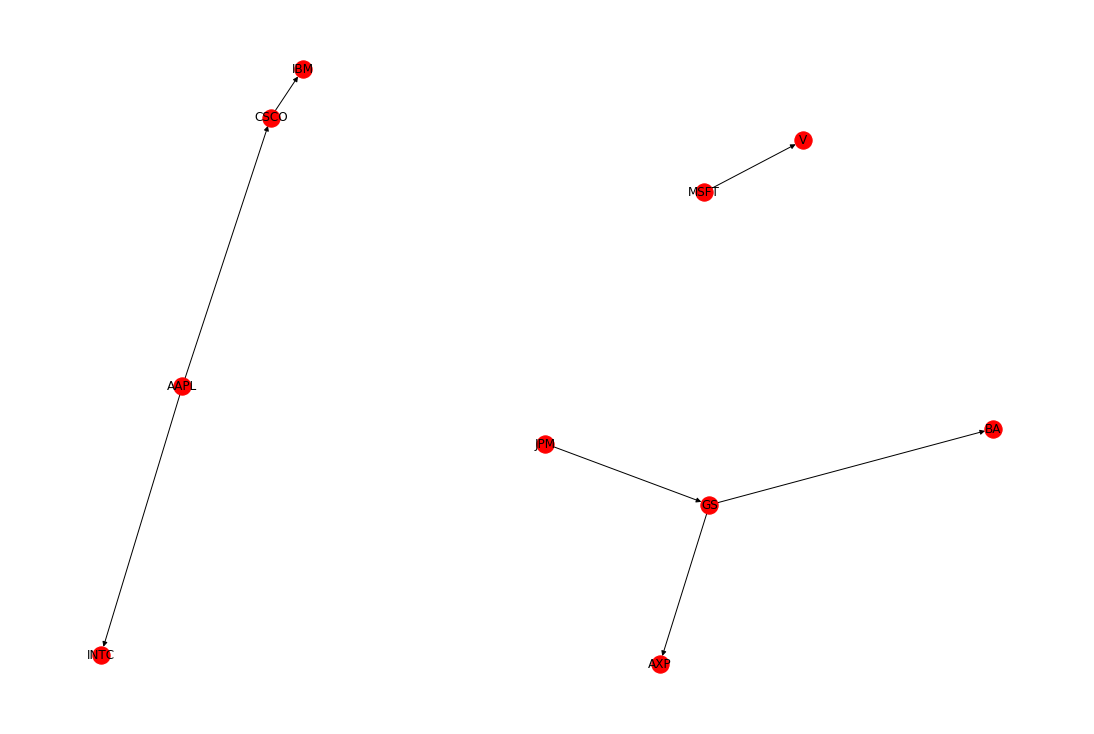

In [37]:
plt.figure(figsize=(15,10))
nx.drawing.layout.random_layout(cbn_prox.graph)
cbn_prox.draw_network(names=list(label))